In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
!mkdir log

ModuleNotFoundError: No module named 'baselines'

In [2]:
import sys,os
sys.path.append('')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
from deep_rl.component.fourrooms_collect import *
from deep_rl.component.fourrooms import *
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
layout = 'open'

if layout == '3rooms' or layout == '3roomsh':
    cell_num = 101
    max_step_dqn = 1e5
    linear_schedule_dqn = 6e4
elif layout == 'maze':
    cell_num = 75
    max_step_dqn = 1.5e5
    linear_schedule_dqn = 9e4
else:
    cell_num = 104
    max_step_dqn = 7e4
    linear_schedule_dqn = 4e4


In [78]:
t = torch.zeros([1, 4, 13, 13])

conv1 = nn.Conv2d(4, 16, 3, 1)

conv2 = nn.Conv2d(16, 32, 3, 1)

pool = nn.MaxPool2d(2, stride=2)

print(t.shape)

t = conv1(t)
print(t.shape, 'after conv1')

t = conv2(t)
print(t.shape, 'after conv2')

t = F.max_pool2d(t, kernel_size=2)
print(t.shape, 'after pooling')

t = torch.flatten(t, 1)
print(t.shape, 'after flatten')



torch.Size([1, 4, 13, 13])
torch.Size([1, 16, 11, 11]) after conv1
torch.Size([1, 32, 9, 9]) after conv2
torch.Size([1, 32, 4, 4]) after pooling
torch.Size([1, 512]) after flatten


In [77]:
dims = 32 * ((13 - (3-1)*2) // 2) ** 2

print(dims)
# layers = nn.ModuleList(
#     [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])

512


In [39]:
# from .network_utils import *
# from .network_bodies import *
# from torch.nn.parameter import Parameter

class DQNCNN(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body=None, hidden_units=(), gate=F.relu, config=1):
        """
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(DQNCNN, self).__init__()
        self.body = body
        self.output_dim = output_dim
        # width 是 observation的边长
        self.width = 13

        # CNN layers
        # Conv2d 的参数 （输入channel， 输出channel，kernel size， kernel位移/stride）
        self.conv1 = nn.Conv2d(4, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.fc_size = 128 * ((self.width - (3-1)*4) // 2) ** 2
        
        self.fc = nn.Linear(2048, 4)
        
        self.gate = gate

    def forward(self, x):
        phi = torch.Tensor(x)
#         print(phi.shape, 'original shape')
#         if self.body is not None:
#             phi = self.body(tensor(x)) # shape: b x state_dim
            
        psi = phi
        
#         print(psi.shape, 'after body shape')

        # Convert to image
        psi = psi.view(phi.size(0), 4, self.width, self.width)

        # Conv layers
        psi = self.conv1(psi)
#         print(psi.shape, 'after conv1')
        psi = F.relu(psi)
        psi = self.conv2(psi)
#         print(psi.shape, 'after conv2')
        psi = F.relu(psi)
        psi = F.max_pool2d(psi, 2)
        
#         print(psi.shape, 'after pooling')
        
        psi = torch.flatten(psi, 1)

        # FC layers
        psi = self.fc(psi)
        
        return psi

In [41]:
learning_rate_dqn = 2e-3 #from 0.05 - 0.001
max_step_dqn = 1e5
linear_schedule_dqn = 6e4

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.DEVICE = torch.device('cpu')
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dqn)
    config.network_fn = lambda: DQNCNN(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(2000,))
#     config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dqn)
    config.discount = 0.9
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dqn
    config.async_actor = False
    agent = DQNAgent(config)

    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.step()
    # plt.figure(figsize=(10,4))
    while True:
        # print(agent.actor._task.env.envs[0].goal)
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        # plt.title('step: {}'.format(agent.total_steps), fontsize=20)
        # plt.imshow(agent.actor._task.env.envs[0].render(), cmap='Blues', )
        agent.switch_task()
    return agent

In [42]:
dqn = dqn_feature(game='FourRoomsCollect')

2021-04-12 19:50:37,050 - root - INFO: steps 0, episodic_return_test 0.30(0.14)
2021-04-12 19:50:56,381 - root - INFO: steps 5000, episodic_return_test 0.60(0.38)
2021-04-12 19:51:11,447 - root - INFO: steps 10000, episodic_return_test 0.90(0.30)
2021-04-12 19:51:27,611 - root - INFO: steps 15000, episodic_return_test 3.20(0.54)
2021-04-12 19:51:42,902 - root - INFO: steps 20000, episodic_return_test 1.90(0.50)
2021-04-12 19:51:58,037 - root - INFO: steps 25000, episodic_return_test 3.80(0.91)
2021-04-12 19:52:13,088 - root - INFO: steps 30000, episodic_return_test 3.10(0.89)
2021-04-12 19:52:28,578 - root - INFO: steps 35000, episodic_return_test 3.60(0.91)
2021-04-12 19:52:44,446 - root - INFO: steps 40000, episodic_return_test 4.50(0.76)
2021-04-12 19:52:59,512 - root - INFO: steps 45000, episodic_return_test 5.90(0.81)
2021-04-12 19:53:14,485 - root - INFO: steps 50000, episodic_return_test 5.00(0.97)
2021-04-12 19:53:29,591 - root - INFO: steps 55000, episodic_return_test 5.00(0.9

In [107]:
env = ClctFourRooms(config=2)

env.reset()

print(env.observation().shape)

(4, 13, 13)


100


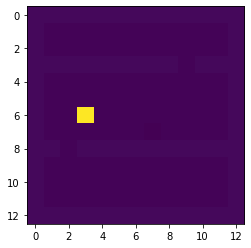

In [115]:
env = FourRoomsMatrix(layout='3roomsh')

print(len(env.init_states))

plt.figure()

plt.imshow(env.reset().reshape([13, 13]))

In [114]:
task = Task('FourRoomsCollect')
# task.state_dim
cnn = DQNCNN(4, None, hidden_units=(2000,))

cnn([env.observation()])

torch.Size([1, 4, 13, 13]) original shape
torch.Size([1, 4, 13, 13]) after body shape
torch.Size([1, 64, 11, 11]) after conv1
torch.Size([1, 128, 9, 9]) after conv2
torch.Size([1, 128, 4, 4]) after pooling


tensor([[ 0.0353, -0.0005,  0.0056, -0.0159]], grad_fn=<AddmmBackward>)

[58, 113, 70, 75, 47, 117, 80, 34, 71, 11]
[58, 113, 70, 75, 47, 117, 80, 34, 71, 11]


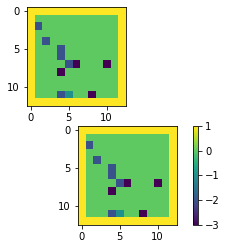

In [25]:
env = ClctFourRooms()
env.reset()
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(env.render())
plt.subplot(2, 1, 2)
plt.imshow(env.render())

plt.colorbar()

In [24]:
class SRNetCNN_MultiChannel(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(3000,), gate=F.relu, config=0):
        """
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetCNN_MultiChannel, self).__init__()
        self.body = body
        self.output_dim = output_dim
        self.width = 13
        self.init_channels = int(self.body.feature_dim / np.square(self.width))

        
        # CNN layers
        self.conv1 = nn.Conv2d(self.init_channels, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
#         self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        self.fc_size = 128 * ((self.width - (3-1)*2) // 2) ** 2

#         # FC layers
#         dims = (self.fc_size,) + hidden_units + (body.feature_dim * output_dim,)
# #         print(self.fc_size, hidden_units, body.feature_dim, output_dim)
# #         print(dims)
#         self.layers = nn.ModuleList(
#             [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
    
#         print(self.layers)

        self.fc = nn.Linear(self.fc_size, int(self.body.feature_dim * output_dim / self.init_channels))
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, 169)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, 169)
        self.to(Config.DEVICE)

    def forward(self, x):
#         print(x.shape, 'original shape')
        phi = self.body(tensor(x)) # shape: b x state_dim
#         print(phi.shape)
#         print(phi.shape)
        psi = phi
        
#         print(psi.shape, 'after body shape')

        # Convert to image
        psi = psi.view(phi.size(0), 4, self.width, self.width)

        # Conv layers
        psi = self.conv1(psi)
#         print(psi.shape, 'after conv1')
        psi = F.relu(psi)
        psi = self.conv2(psi)
#         print(psi.shape, 'after conv2')
        psi = F.relu(psi)
        psi = F.max_pool2d(psi, 2)
        
#         print(psi.shape, 'after pooling')
        
        psi = torch.flatten(psi, 1)

        # FC layers
#         for layer in self.layers[:-1]:
#             psi = self.gate(layer(psi))
#         psi = self.layers[-1](psi)
        psi = self.fc(psi)
        
#         print(f'debug : {psi.shape}, {psi.size(0)}, {self.output_dim}, {self.body.feature_dim}')
        
        psi = psi.view(psi.size(0), self.output_dim, 169) # shape: b x action_dim x state_dim
        
#         print(f'after view shape : {psi.shape}')
        out = self.psi2q(psi)
        phi = phi[:, 1, :, :]

        return phi, psi, out

In [29]:
task = Task('FourRoomsCollectNoTerm')

cnn = SRNetCNN_MultiChannel(4, SRIdentityBody(task.state_dim), \
                                      hidden_units=(2000,), config=0)

ipt = np.zeros([10, 4, 13, 13])

a, b, c = cnn(ipt)
print(cnn)

print(a.shape)
print(b.shape)
print(c.shape)

SRNetCNN_MultiChannel(
  (body): SRIdentityBody()
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=2048, out_features=676, bias=True)
  (psi2q): Psi2QNet()
)
torch.Size([10, 13, 13])
torch.Size([10, 4, 169])
torch.Size([10, 4])


In [22]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.async_actor = False
    config.DEVICE = torch.device('0')

    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
#     config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), \
#                                       hidden_units=(2000,), config=config.style) #CHECK

    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(2000,), config=config.style) #CHECK
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dqn)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dqn
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [23]:
dsr = dsr_feature_init(ref=None, game='FourRoomsMatrix', freeze=0, style=0)

<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-04-13 15:26:21,749 - root - INFO: steps 0, episodic_return_test -200.00(0.00)


time for one step: 5.1883 seconds
time for one step: 0.0079 seconds
time for one step: 0.0074 seconds
time for one step: 0.0075 seconds
time for one step: 0.0072 seconds
time for one step: 0.0070 seconds
time for one step: 0.0068 seconds
time for one step: 0.0073 seconds
time for one step: 0.0071 seconds
time for one step: 0.0068 seconds
time for one step: 0.0071 seconds
time for one step: 0.0071 seconds
time for one step: 0.0074 seconds
time for one step: 0.0073 seconds
time for one step: 0.0070 seconds
time for one step: 0.0070 seconds
time for one step: 0.0071 seconds
time for one step: 0.0070 seconds
time for one step: 0.0068 seconds
time for one step: 0.0075 seconds
time for one step: 0.0068 seconds
time for one step: 0.0071 seconds
time for one step: 0.0066 seconds
time for one step: 0.0073 seconds
time for one step: 0.0077 seconds
time for one step: 0.0077 seconds
time for one step: 0.0089 seconds
time for one step: 0.0097 seconds
time for one step: 0.0113 seconds
time for one s

KeyboardInterrupt: 

In [8]:
max_step_avdsr = 1e5
linear_schedule_avdsr = 1e5
learning_rate_avdsr = 1e-3 #from 0.05 - 0.001

def avdsr_feature_A(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_avdsr)
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                                       hidden_units=(), config=0) #CHECK
    config.network_fn = lambda: SRNetCNN_MultiChannel(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(2000,), config=config.style) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, linear_schedule_avdsr) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = max_step_avdsr
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.network = load_agent('avdsr-A')
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
#             store_agent(agent.network, 'avdsr-A-'+game)
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
      

In [9]:
avdsr = avdsr_feature_A(game='FourRoomsMatrix', agents=[None], choice=0, style=0)

2021-04-12 20:39:31,278 - root - INFO: steps 0, 349525333.33 steps/s


no key


AttributeError: 'NoneType' object has no attribute 'network'